In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import datetime
import string, re, emoji
import itertools
from collections import Counter
from typing import Iterable, Any
# Libraries for text preprocessing.

import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from wordcloud import WordCloud,STOPWORDS
# Text Preprocessing
import morfeusz2

# Loading some sklearn packaces
from sklearn.feature_extraction.text import CountVectorizer

# Some packages for word clouds and NER.

from wordcloud import WordCloud, STOPWORDS
from collections import Counter, defaultdict
from PIL import Image
import spacy
import morfeusz2
import pl_core_news_md

# Core packages for general use throughout the notebook.


import warnings
from pathlib import Path

# For customizing our plots.

from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches



# For building ML models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV 

# models and validation
from sklearn import naive_bayes, svm
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

#SMOTE
from imblearn.over_sampling import SMOTE

stop = set(stopwords.words('polish'))
sns.set(font_scale=1.5)
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')


In [23]:
DATAPATH = Path('../data/processed/Tweety25k-1.csv')
STOPWORDS = Path('../data/raw/polish_stopwords.txt')

In [24]:
df = pd.read_csv(DATAPATH)
df = pd.concat([df[df['label'] == "1"], df[df['label'] == "0"]])
df.label = df.label.astype(int)


df = df.sample(frac = 1).reset_index(drop=True)
df.head()

,id,text,label
0,1634469016742813696,"@michaldworczyk Spotkanie z gościem, który odp...",0
1,1634652740633632769,"@jaroslawmerkli1 @JkmMikke Ja przez 30, teraz ...",0
2,1634969396996104194,@M_K_Blonska Nasza krynica mądrości zabrała głos.,0
3,1635584456382640128,"@PatrykJaki Głębokie przekonanie o ""swojej pra...",0
4,1634216942771765251,@kamonke22 @marian_konarski @mblaszczak Nie ka...,0


# Preprocessing

In [25]:
morf = morfeusz2.Morfeusz()

def lowercase(text: str) -> str:
    """Converts letters in given text to lowercase.
    Args:
        text (str): Text to preprocess.
    Returns:
        preprocessedText (str): Lowercase text.

    """
    preprocessedText = str.lower(str(text))
    return  preprocessedText

def remove_hashtags(text: str) -> str:
    """Removes hashtags from given tweet text.
    Args:
        text (str): Text to preprocess.
    Returns:
        preprocessedText (str): Text with no hashtags.

    """
    preprocessedText = re.sub('#[a-zA-Z0-9_]+', '', text )

    return preprocessedText

def remove_mentions(text: str) -> str:
    """Removes mentions from given tweet text.
    Args:
        text (str): Text to preprocess.
    Returns:
        preprocessedText (str): Text with no mentions.

    """
    preprocessedText = re.sub('@[a-zA-Z0-9_]+', '', text )

    return preprocessedText

def remove_punctuation(text: str) -> str:
    """Removes non text characters from given tweet text.
    Args:
        text (str): Text to preprocess.
    Returns:
        preprocessedText (str): Text with no non tex characters.

    """
    preprocessedText = text.translate(str.maketrans('', '', string.punctuation))

    return preprocessedText

def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def lemmatize(text: str) -> str:
    """Lemmatizes polish text from given tweet.
    Args:
        text (str): Text to preprocess.
    Returns:
        lemmatizedText (str): Lemmatized text.

    """
    wordList = text.split()
    lemmatizedWordList = []

    for word in wordList:    
        _, _, interpretation = morf.analyse(word)[0]
        lemWord = interpretation[1]
        lemWordStripped = lemWord.split(':', 1)[0].lower()
        lemmatizedWordList.append(lemWordStripped)

    lemmatizedText = ' '.join(lemmatizedWordList)

    return lemmatizedText

def remove_html(text):
    """_summary_

    Args:
        text (_type_): _description_

    Returns:
        _type_: _description_
    """
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

def remove_stopwords(text: str) -> str:
    """Removes stopwords.
    Args:
        text (str): Text to preprocess.
    Returns:
        preprocessedText (str): Text with no stopwords.

    """
    wordList = text.split() 
    preprecessedWordList = []

    stopWords = stopwords.words('polish')
    # stopWords += ['rt']

    for word in wordList:
        if word not in stopWords:
            preprecessedWordList.append(word)

    preprocessedText = ' '.join(preprecessedWordList)

    return preprocessedText

In [26]:
df.head()

,id,text,label
0,1634469016742813696,"@michaldworczyk Spotkanie z gościem, który odp...",0
1,1634652740633632769,"@jaroslawmerkli1 @JkmMikke Ja przez 30, teraz ...",0
2,1634969396996104194,@M_K_Blonska Nasza krynica mądrości zabrała głos.,0
3,1635584456382640128,"@PatrykJaki Głębokie przekonanie o ""swojej pra...",0
4,1634216942771765251,@kamonke22 @marian_konarski @mblaszczak Nie ka...,0


In [27]:
# Remove blank rows if any.
df['label'].dropna(inplace=True)

# Applying helper functions

df['text_clean'] = df['text'].apply(lambda x: lowercase(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_hashtags(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_mentions(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_emoji(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_html(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_punctuation(x))
df['text_clean'] = df['text_clean'].apply(lambda x: lemmatize(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_stopwords(x))
df['tokenized'] = [word_tokenize(entry, language="polish") for entry in df['text_clean']]
df['text_clean']= [str(word_tokenize(entry)) for entry in df['text_clean']]

df['text_str'] = df['text_clean'].apply(lambda x: ' '.join(eval(x)))

In [28]:
df.head()

,id,text,label,text_clean,tokenized,text_str
0,1634469016742813696,"@michaldworczyk Spotkanie z gościem, który odp...",0,"['spotkać', 'gość', 'odpowiadać', 'defraudacja...","[spotkać, gość, odpowiadać, defraudacja, środk...",spotkać gość odpowiadać defraudacja środki res...
1,1634652740633632769,"@jaroslawmerkli1 @JkmMikke Ja przez 30, teraz ...",0,"['30', 'przerzucać', 'kononowicz', 'rozważać',...","[30, przerzucać, kononowicz, rozważać, tenże, ...",30 przerzucać kononowicz rozważać tenże kandyd...
2,1634969396996104194,@M_K_Blonska Nasza krynica mądrości zabrała głos.,0,"['naszać', 'krynica', 'mądrość', 'zabrać', 'gł...","[naszać, krynica, mądrość, zabrać, głos]",naszać krynica mądrość zabrać głos
3,1635584456382640128,"@PatrykJaki Głębokie przekonanie o ""swojej pra...",0,"['głęboki', 'przekonać', 'swój', 'prawda', 'in...","[głęboki, przekonać, swój, prawda, indoktrynow...",głęboki przekonać swój prawda indoktrynować cz...
4,1634216942771765251,@kamonke22 @marian_konarski @mblaszczak Nie ka...,0,"['chcieć', 'wojna', 'ruski']","[chcieć, wojna, ruski]",chcieć wojna ruski


In [29]:
#Divide sets
X_train, X_test, y_train, y_test = train_test_split(df["text_clean"],df["label"],test_size=.15)

#Encode labels
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(y_train)
Test_Y = Encoder.fit_transform(y_test)
Whole_Y = Encoder.fit_transform(df["label"])

# Convert a collection of raw documents to a matrix of TF-IDF features.
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(df['text_clean'])
Train_X_Tfidf = Tfidf_vect.transform(X_train)
Test_X_Tfidf = Tfidf_vect.transform(X_test)
Whole_X_Tfidf = Tfidf_vect.transform(df['text_clean'])

# Machine Learning models

In [30]:
from typing import Iterable


def generate_perf_report(
    X: Iterable,
    y: Iterable,
    *,
    name: str = "sample",
    description: str = "no description",
    clf: Any = None,
    date_fmt: str = "%Y-%m-%d %H:%M:%S",
    test_size: float = 0.15,
) -> pd.Series:
    """
    Generate a report gathering main model classification metrics.

    Parameters
    ----------
    X : iterable of shape (n_samples, n_features)
        Sparse matrix of shape (n_samples, n_features).
    y : iterable
        Target values (class labels).
    name : str
        Name of the report, by default "sample".
    description : str
        Optional description for better understanding of the report.
    clf : Any
        Vector classification. Defaults to C-Support Vector Classification
        (`sklearn.svm.SVC`).
    test_size : float or int, default=0.15
        See `sklearn.model_selection.train_test_split` documentation
        for details on this parameter.
    date_fmt : str, default="%Y-%m-%d %H:%M:%S"
        Date format.

    Returns
    -------
    report : pd.Series
        Report with specified name, date, description, test size,
        precision score, recall score, f-measure, accuracy and ROC
        AUC score in human-friendly format.
    """  # needs review
    date = datetime.datetime.now().strftime(date_fmt)

    clf = clf or svm.SVC()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    model = clf.fit(X_train, y_train)
    predictions = model.predict(X_test)  # type: ignore

    return pd.Series(
        {
            "Date": date,
            "Description": description,
            "Test Size": test_size,
            "Precision": metrics.precision_score(y_test, predictions),
            "Recall": metrics.recall_score(y_test, predictions),
            # F-measure
            "F1 Score": metrics.f1_score(y_test, predictions),
            "Accuracy": metrics.accuracy_score(y_test, predictions),
            # Area Under the Receiver Operating Characteristic Curve (ROC AUC)
            "Roc_auc_score": metrics.roc_auc_score(y_test, predictions),
            "Confusion Matrix": metrics.confusion_matrix(y_test, predictions),
            "Roc curve": metrics.roc_curve(y_test, predictions),
        },
        name=name,
    )


# Logistic Regression

In [31]:
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'lbfgs', 'sag', 'saga']
}

scoring = {
    'accuracy': 'accuracy',
    'recall': 'recall',
    'precision': 'precision',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

In [32]:
logistic = LogisticRegression()
logistic.fit(Train_X_Tfidf,Train_Y)

predictions_LR = logistic.predict(Test_X_Tfidf)

Model test:
		Prec: 0.8148148148148148         
		 Rec: 0.13836477987421383         
		 F1: 0.23655913978494625         
		 Acc: 0.9547770700636943


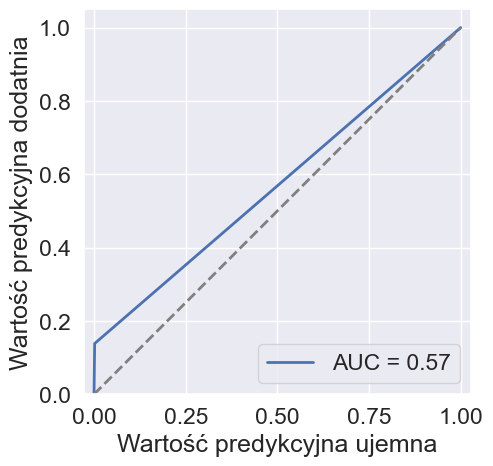

In [33]:
print('Model test:')

print(f'\t\tPrec: {metrics.precision_score(Test_Y, predictions_LR)} \
        \n\t\t Rec: {metrics.recall_score(Test_Y, predictions_LR)} \
        \n\t\t F1: {metrics.f1_score(Test_Y, predictions_LR)} \
        \n\t\t Acc: {metrics.accuracy_score(Test_Y, predictions_LR)}')

# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(Test_Y, predictions_LR)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(5, 5))
plt.axis('equal')
plt.plot(fpr, tpr, lw=2, label="AUC = %0.2f" % roc_auc)
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Wartość predykcyjna ujemna")
plt.ylabel("Wartość predykcyjna dodatnia")
plt.legend(loc="lower right")
plt.show()

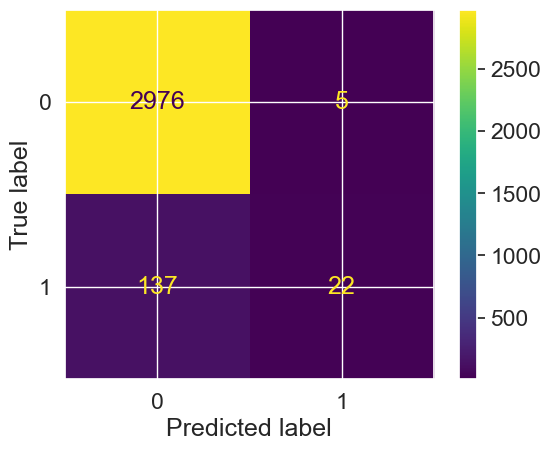

In [34]:
cm = metrics.confusion_matrix(Test_Y, predictions_LR, labels=logistic.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=logistic.classes_)
disp.plot()

In [35]:
grid_search = GridSearchCV(estimator=logistic, param_grid=param_grid, scoring=scoring, cv=5, refit='f1')
grid_search.fit(Train_X_Tfidf,Train_Y)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1.0, 10.0], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'lbfgs', 'sag', 'saga']},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [36]:
best_model_lr = grid_search.best_estimator_

In [37]:
tfdf_lr = generate_perf_report(
    Whole_X_Tfidf,
    Whole_Y,
    name='Logistic Regression',
    description='basic NB classifier',
    clf=best_model_lr
     )

In [38]:
logis = generate_perf_report(
    Whole_X_Tfidf,
    Whole_Y,
    name='Logistic Regression',
    description='basic NB classifier',
    clf=LogisticRegression()
     )

# Naive Bayes

In [39]:
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",metrics.accuracy_score(predictions_NB, Test_Y)*100)

Naive Bayes Accuracy Score ->  95.22292993630573


Model test:
		Prec: 1.0         
		 Rec: 0.05660377358490566         
		 F1: 0.10714285714285715         
		 Acc: 0.9522292993630573


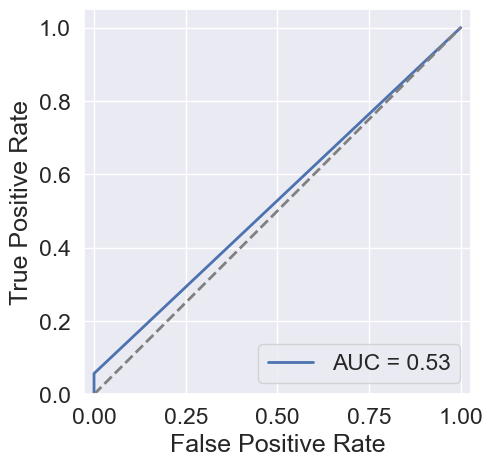

In [40]:
print('Model test:')

print(f'\t\tPrec: {metrics.precision_score(Test_Y, predictions_NB)} \
        \n\t\t Rec: {metrics.recall_score(Test_Y, predictions_NB)} \
        \n\t\t F1: {metrics.f1_score(Test_Y, predictions_NB)} \
        \n\t\t Acc: {metrics.accuracy_score(Test_Y, predictions_NB)}')

# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(Test_Y, predictions_NB)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(5, 5))
plt.axis('equal')
plt.plot(fpr, tpr, lw=2, label="AUC = %0.2f" % roc_auc)
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

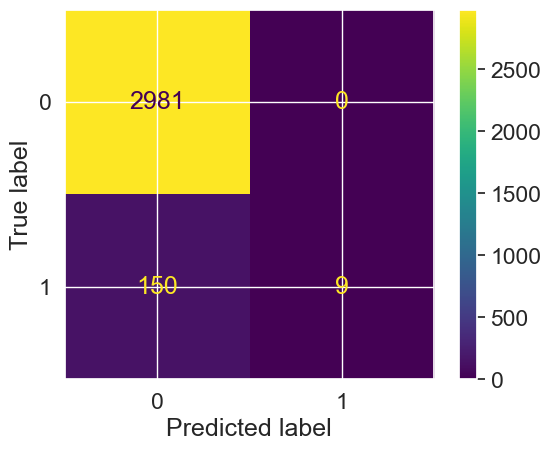

In [41]:
cm = metrics.confusion_matrix(Test_Y, predictions_NB, labels=Naive.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=Naive.classes_)
disp.plot()

In [42]:
naive = generate_perf_report(
    Whole_X_Tfidf,
    Whole_Y,
    name='NaiveBayes',
    description='basic NB classifier',
    clf=naive_bayes.MultinomialNB()
     )

In [43]:
param_grid = {
    'alpha': [0.1, 1.0, 10.0],
    'fit_prior': [True, False]
}
grid_search = GridSearchCV(estimator=naive_bayes.MultinomialNB(), param_grid=param_grid, scoring=scoring, cv=5, refit='f1')
grid_search.fit(Train_X_Tfidf,Train_Y)

best_model = grid_search.best_estimator_
print(best_model)
generate_perf_report(
    Whole_X_Tfidf,
    Whole_Y,
    name='Logistic Regression',
    description='basic NB classifier',
    clf=best_model
     ).to_dict()

MultinomialNB(alpha=0.1, fit_prior=False)


{'Date': '2023-06-21 00:17:59',
 'Description': 'basic NB classifier',
 'Test Size': 0.15,
 'Precision': 0.18003273322422259,
 'Recall': 0.6626506024096386,
 'F1 Score': 0.2831402831402831,
 'Accuracy': 0.8226114649681529,
 'Roc_auc_score': 0.7470953079297689,
 'Confusion Matrix': array([[2473,  501],
        [  56,  110]], dtype=int64),
 'Roc curve': (array([0.        , 0.16845999, 1.        ]),
  array([0.       , 0.6626506, 1.       ]),
  array([2, 1, 0], dtype=int64))}

# SVM

In [44]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC()
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",metrics.accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  95.50955414012738


Model test:
		Prec: 0.8         
		 Rec: 0.1509433962264151         
		 F1: 0.25396825396825395         
		 Acc: 0.9550955414012738         
		 ROC_AUC: 0.5744653244131068


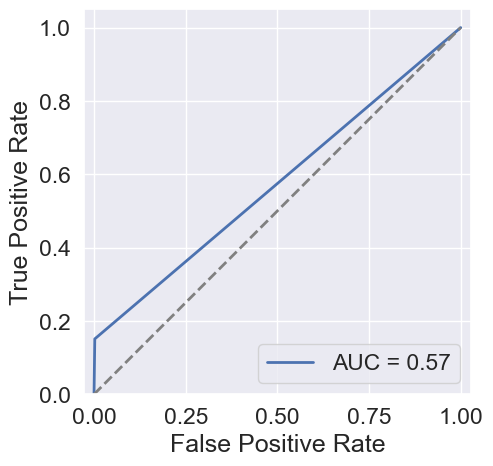

In [45]:
print('Model test:')

print(f'\t\tPrec: {metrics.precision_score(Test_Y, predictions_SVM)} \
        \n\t\t Rec: {metrics.recall_score(Test_Y, predictions_SVM)} \
        \n\t\t F1: {metrics.f1_score(Test_Y, predictions_SVM)} \
        \n\t\t Acc: {metrics.accuracy_score(Test_Y, predictions_SVM)} \
        \n\t\t ROC_AUC: {metrics.roc_auc_score(Test_Y, predictions_SVM)}')

# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(Test_Y, predictions_SVM)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(5, 5))
plt.axis('equal')
plt.plot(fpr, tpr, lw=2, label="AUC = %0.2f" % roc_auc)
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

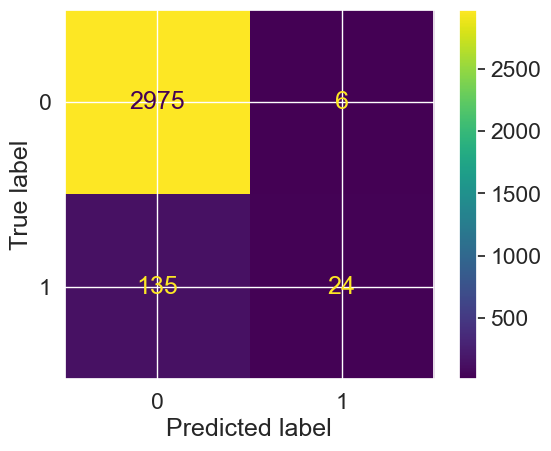

In [46]:
cm = metrics.confusion_matrix(Test_Y, predictions_SVM, labels=SVM.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=SVM.classes_)
disp.plot()

In [47]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(estimator=svm.SVC(), param_grid=param_grid, scoring=scoring, cv=5, refit='f1')
grid_search.fit(Train_X_Tfidf,Train_Y)

best_model = grid_search.best_estimator_
print(best_model)
generate_perf_report(
    Whole_X_Tfidf,
    Whole_Y,
    name='Logistic Regression',
    description='basic NB classifier',
    clf=best_model
     ).to_dict()

SVC(C=10, kernel='linear')


{'Date': '2023-06-21 00:27:08',
 'Description': 'basic NB classifier',
 'Test Size': 0.15,
 'Precision': 0.46621621621621623,
 'Recall': 0.3556701030927835,
 'F1 Score': 0.40350877192982454,
 'Accuracy': 0.935031847133758,
 'Roc_auc_score': 0.6644270406842058,
 'Confusion Matrix': array([[2867,   79],
        [ 125,   69]], dtype=int64),
 'Roc curve': (array([0.        , 0.02681602, 1.        ]),
  array([0.       , 0.3556701, 1.       ]),
  array([2, 1, 0], dtype=int64))}

In [48]:
svc = generate_perf_report(
    Whole_X_Tfidf,
    Whole_Y,
    name='SVC',
    description='basic SVM',
    clf=svm.SVC()
     )

As we see, unbalanced data is not our friend.

# Synthetic Minority Oversampling Technique

https://arxiv.org/abs/2008.04636
<br> "...In most
cases, the use of oversampling techniques can significantly improve the
quality of classification."

# Oversampling

In [49]:
X = df['text_clean'].copy()
y = df['label'].copy()

In [50]:
# Convert a collection of raw documents to a matrix of TF-IDF features.
Tfidf_vect = TfidfVectorizer(max_features=5000)
X = Tfidf_vect.fit_transform(X)

In [51]:
# summarize class distribution
counter = Counter(y)
print(counter)

Counter({0: 19784, 1: 1144})


In [52]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [53]:
counter = Counter(y)
print(counter)

Counter({0: 19784, 1: 19784})


In [54]:
#Divide sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.15)

#Encode labels
# Encoder = LabelEncoder()
# Train_Y = Encoder.fit_transform(y_train)
# Test_Y = Encoder.fit_transform(y_test)


### LR SMOTE

In [55]:
best_model_lr.fit(X_train,y_train)
# predict the labels on validation dataset
predictions_LR = best_model_lr.predict(X_test)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",metrics.accuracy_score(predictions_LR, y_test)*100)

Naive Bayes Accuracy Score ->  91.07142857142857


Model test:
		Prec: 0.8570605187319885         
		 Rec: 0.9886968085106383         
		 F1: 0.9181846248842236         
		 Acc: 0.9107142857142857


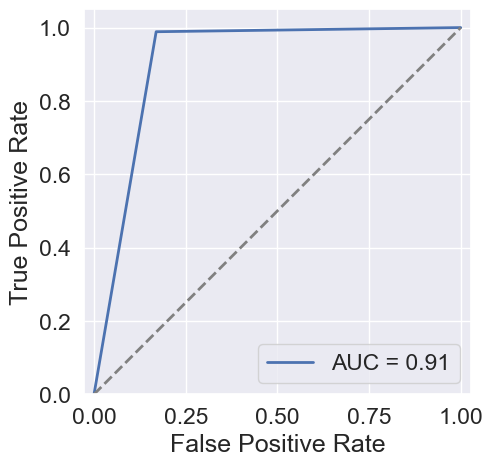

In [56]:
print('Model test:')

print(f'\t\tPrec: {metrics.precision_score(y_test, predictions_LR)} \
        \n\t\t Rec: {metrics.recall_score(y_test, predictions_LR)} \
        \n\t\t F1: {metrics.f1_score(y_test, predictions_LR)} \
        \n\t\t Acc: {metrics.accuracy_score(y_test, predictions_LR)}')

# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions_LR)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(5, 5))
plt.axis('equal')
plt.plot(fpr, tpr, lw=2, label="AUC = %0.2f" % roc_auc)
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [57]:
lr_oversampled = generate_perf_report(
    X,
    y,
    name='NaiveBayesOversampled',
    description='NB classifier with oversampling',
    clf=naive_bayes.MultinomialNB()
     )

### Naive Bayes

In [58]:
Naive = naive_bayes.MultinomialNB()
Naive.fit(X_train,y_train)
# predict the labels on validation dataset
predictions_NB = Naive.predict(X_test)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",metrics.accuracy_score(predictions_NB, y_test)*100)

Naive Bayes Accuracy Score ->  87.26415094339622


Model test:
		Prec: 0.8629916183107672         
		 Rec: 0.8899601063829787         
		 F1: 0.8762684124386252         
		 Acc: 0.8726415094339622


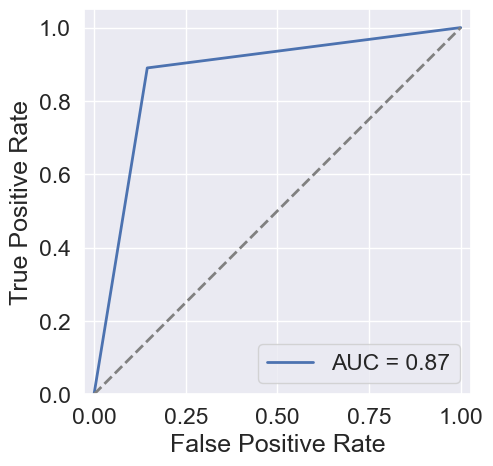

In [59]:
print('Model test:')

print(f'\t\tPrec: {metrics.precision_score(y_test, predictions_NB)} \
        \n\t\t Rec: {metrics.recall_score(y_test, predictions_NB)} \
        \n\t\t F1: {metrics.f1_score(y_test, predictions_NB)} \
        \n\t\t Acc: {metrics.accuracy_score(y_test, predictions_NB)}')

# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions_NB)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(5, 5))
plt.axis('equal')
plt.plot(fpr, tpr, lw=2, label="AUC = %0.2f" % roc_auc)
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [66]:
cm

array([[2503,  425],
       [ 331, 2677]], dtype=int64)

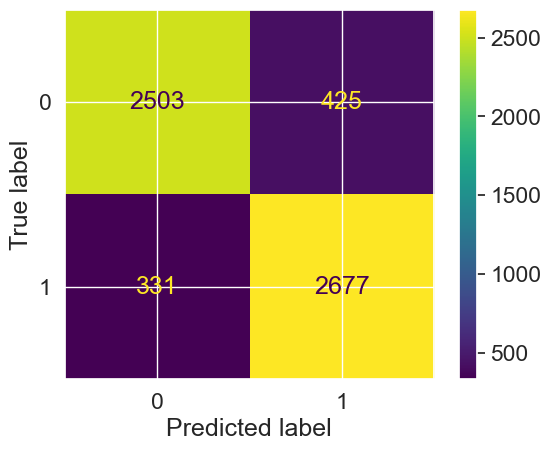

In [60]:
cm = metrics.confusion_matrix(y_test, predictions_NB, labels=Naive.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=Naive.classes_)
disp.plot()

In [61]:
naive_oversampled = generate_perf_report(
    X,
    y,
    name='NaiveBayesOversampled',
    description='NB classifier with oversampling',
    clf=naive_bayes.MultinomialNB()
     )

### SVM

In [62]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC()
SVM.fit(X_train, y_train)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy on non oversampled data
print("SVM Accuracy Score -> ",metrics.accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  97.00636942675159


In [63]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC()
SVM.fit(X_train, y_train)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(X_test)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",metrics.accuracy_score(predictions_SVM, y_test)*100)

SVM Accuracy Score ->  97.84366576819407


Model test:
		Prec: 0.9615384615384616         
		 Rec: 0.9973404255319149         
		 F1: 0.97911227154047         
		 Acc: 0.9784366576819407         
		 ROC_AUC: 0.9781784094872689


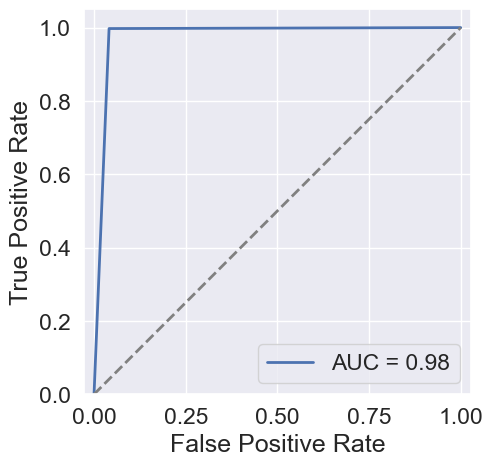

In [64]:
print('Model test:')

print(f'\t\tPrec: {metrics.precision_score(y_test, predictions_SVM)} \
        \n\t\t Rec: {metrics.recall_score(y_test, predictions_SVM)} \
        \n\t\t F1: {metrics.f1_score(y_test, predictions_SVM)} \
        \n\t\t Acc: {metrics.accuracy_score(y_test, predictions_SVM)} \
        \n\t\t ROC_AUC: {metrics.roc_auc_score(y_test, predictions_SVM)}')

# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions_SVM)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(5, 5))
plt.axis('equal')
plt.plot(fpr, tpr, lw=2, label="AUC = %0.2f" % roc_auc)
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [67]:
SVM = svm.SVC(probability=True)
SVM.fit(X_train, y_train)
# predict the labels on validation dataset
predictions_SVM = SVM.predict_proba(X_test)

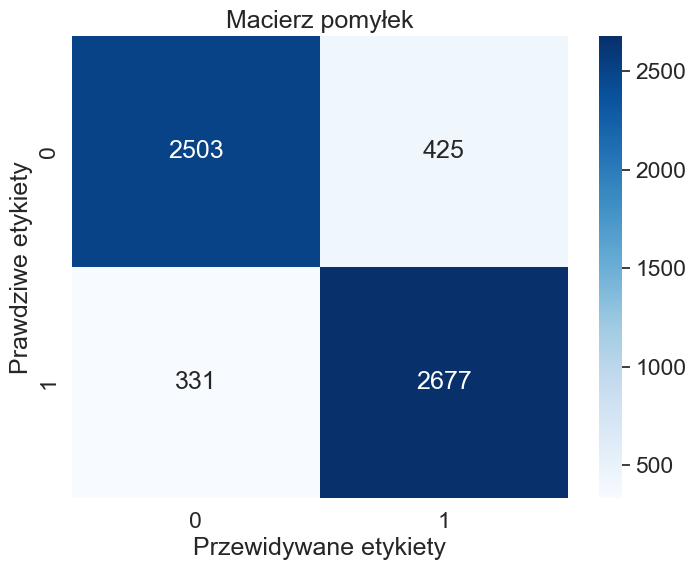

In [69]:
# Definiowanie etykiet klas
labels = [0,1]

# Tworzenie wykresu macierzy pomyłek
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Przewidywane etykiety')
plt.ylabel('Prawdziwe etykiety')
plt.title('Macierz pomyłek')
plt.show()

In [70]:
svc_oversampled = generate_perf_report(
    X,
    y,
    name='SVMOversampled',
    description='SVM classifier with oversampling',
    clf=svm.SVC()
     )

# Benchmark

In [71]:
pd.concat([tfdf_lr, lr_oversampled, naive, naive_oversampled, svc, svc_oversampled], axis=1).T

,Date,Description,Test Size,Precision,Recall,F1 Score,Accuracy,Roc_auc_score,Confusion Matrix,Roc curve
Logistic Regression,2023-06-21 00:17:44,basic NB classifier,0.15,0.420168,0.301205,0.350877,0.941083,0.639002,"[[2905, 69], [116, 50]]","([0.0, 0.02320107599193006, 1.0], [0.0, 0.3012..."
NaiveBayesOversampled,2023-06-21 00:28:32,NB classifier with oversampling,0.15,0.86686,0.89783,0.882073,0.878875,0.878701,"[[2528, 413], [306, 2689]]","([0.0, 0.14042842570554234, 1.0], [0.0, 0.8978..."
NaiveBayes,2023-06-21 00:17:59,basic NB classifier,0.15,1.0,0.023392,0.045714,0.946815,0.511696,"[[2969, 0], [167, 4]]","([0.0, 0.0, 1.0], [0.0, 0.023391812865497075, ..."
NaiveBayesOversampled,2023-06-21 00:28:33,NB classifier with oversampling,0.15,0.834163,0.91941,0.874715,0.87062,0.87146,"[[2487, 533], [235, 2681]]","([0.0, 0.17649006622516555, 1.0], [0.0, 0.9194..."
SVC,2023-06-21 00:27:16,basic SVM,0.15,0.923077,0.138728,0.241206,0.951911,0.569027,"[[2965, 2], [149, 24]]","([0.0, 0.0006740815638692282, 1.0], [0.0, 0.13..."
SVMOversampled,2023-06-21 01:00:46,SVM classifier with oversampling,0.15,0.964837,0.999319,0.981776,0.981637,0.981814,"[[2891, 107], [2, 2936]]","([0.0, 0.03569046030687125, 1.0], [0.0, 0.9993..."


In [ ]:
# with open("table.tex", 'w') as f:
#     f.write(pd.concat([tfdf_lr, lr_oversampled, naive, naive_oversampled, svc, svc_oversampled], axis=1).T[["Description", "Test Size", "Precision", "Recall", "F1 Score", "Accuracy", "Roc_auc_score"]].to_latex(index=False))

Outcomes: With oversampling SVM is almost ideall.